<a href="https://www.kaggle.com/code/pkhamchuai/breast-cancer-prediction-dnn?scriptVersionId=104187612" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Notes to readers
**This is my first attemp on a prediction task. I'm not familiar with this type of problem at all. I'm trying to use a DNN to predict a mortality of the patient. For now I'm satisfied with the results, but, sure, it could be better.  If you have any suggestions on the network architecture or other things that could potentially improve the performance, please leave a comment. Thank you.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import tensorflow as tf

/kaggle/input/breast-cancer/Breast_Cancer.csv


# Data processing

In [2]:
df = pd.read_csv('/kaggle/input/breast-cancer/Breast_Cancer.csv', sep = ',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [3]:
df.shape

(4024, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [5]:
le = LabelEncoder()
df['Race'] = le.fit_transform(df['Race'])
df['Marital Status'] = le.fit_transform(df['Marital Status'])
df['N Stage'] = le.fit_transform(df['N Stage'])
df['6th Stage'] = le.fit_transform(df['6th Stage'])
df['differentiate'] = le.fit_transform(df['differentiate'])
df['Grade'] = le.fit_transform(df['Grade'])
df['A Stage'] = le.fit_transform(df['A Stage'])
df['Estrogen Status'] = le.fit_transform(df['Estrogen Status'])
df['Progesterone Status'] = le.fit_transform(df['Progesterone Status'])
df['Status'] = le.fit_transform(df['Status'])
df['T Stage '] = le.fit_transform(df['T Stage '])

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4024.0,53.972167,8.963134,30.0,47.0,54.0,61.0,69.0
Race,4024.0,1.775845,0.564465,0.0,2.0,2.0,2.0,2.0
Marital Status,4024.0,1.371272,1.063637,0.0,1.0,1.0,1.0,4.0
T Stage,4024.0,0.784791,0.765531,0.0,0.0,1.0,1.0,3.0
N Stage,4024.0,0.438370,0.693479,0.0,0.0,0.0,1.0,2.0
6th Stage,4024.0,1.321819,1.266624,0.0,0.0,1.0,2.0,4.0
differentiate,4024.0,0.690358,1.016418,0.0,0.0,0.0,1.0,3.0
Grade,4024.0,2.131710,0.642398,0.0,2.0,2.0,3.0,3.0
A Stage,4024.0,0.977137,0.149485,0.0,1.0,1.0,1.0,1.0
Tumor Size,4024.0,30.473658,21.119696,1.0,16.0,25.0,38.0,140.0


In [7]:
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,2,1,0,0,0,1,3,1,4,1,1,24,1,60,0
1,50,2,1,1,1,2,0,2,1,35,1,1,14,5,62,0
2,58,2,0,2,2,4,0,2,1,63,1,1,14,7,75,0
3,58,2,1,0,0,0,1,3,1,18,1,1,2,1,84,0
4,47,2,1,1,0,1,1,3,1,41,1,1,3,1,50,0


In [8]:
dataset = pd.get_dummies(df) # It's not really necessary after LabelEncoder


In [9]:
dataset.isna().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Status')
test_labels = test_features.pop('Status')

In [12]:
# Class weighting
print("[INFO] Class weighting...")
class_weights = class_weight.compute_class_weight(
                                                  'balanced',
                                                  classes=np.unique(np.ravel(train_labels, order='C')),
                                                  y=np.ravel(train_labels, order='C'))

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

[INFO] Class weighting...
{0: 0.5912931667891257, 1: 3.238430583501006}


### The Normalization layer

In [13]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2022-08-25 14:35:05.612018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 14:35:05.721626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 14:35:05.722394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 14:35:05.724466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

[[53.865795    1.7713574   1.3777574   0.7974525   0.4392669   1.3336434
   0.6859274   2.1317177   0.97576886 30.810802    0.93414104  0.8254116
  14.3960905   4.168064   71.43554   ]]


# Regression with a deep neural network (DNN)

In [14]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'Actual is 0 and Prediction is 0: ', cm[0][0])
    print(f'Actual is 0 and Prediction is 1: ', cm[0][1])
    print(f'Actual is 1 and Prediction is 0: ', cm[1][0])
    print(f'Actual is 1 and Prediction is 1: ', cm[1][1])
    print(f'Total Correct Prediction: {np.sum(cm[0][0] + cm[1][1])} / {np.sum(cm)}')

In [15]:
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

2.6.4
Found GPU at: /device:GPU:0


2022-08-25 14:35:08.679210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 14:35:08.679748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 14:35:08.680124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 14:35:08.680509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 14:35:08.680833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [16]:
model = Sequential([
      #normalizer,
      layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
      layers.Dropout(0.2),
      layers.Dense(128),
      layers.Dense(1, activation='sigmoid')
  ])

In [17]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=20, mode='max', restore_best_weights=True)

LR = 1e-4
EPOCHS = 100
optim = Adam(learning_rate=LR, decay=LR / EPOCHS)

model.compile(optimizer=optim, 
              loss=losses.binary_crossentropy, metrics=['accuracy'])

In [18]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=EPOCHS,
    verbose=0,
    validation_split = 0.2,
    callbacks=[es],
    class_weight=class_weight_dict)

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
CPU times: user 10.8 s, sys: 1.21 s, total: 12 s
Wall time: 10.4 s


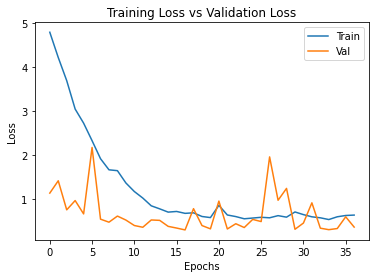

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

In [20]:
print("[INFO] Calculating model accuracy")
train_scores = model.evaluate(train_features, train_labels)
test_scores = model.evaluate(test_features, test_labels)
print(f"Test Accuracy (on train dataset): {train_scores[1]*100}")
print(f"Test Accuracy (on test dataset): {test_scores[1]*100}")

[INFO] Calculating model accuracy
26/26 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.9006
Test Accuracy (on train dataset): 88.6610746383667
Test Accuracy (on test dataset): 90.06211161613464


In [21]:
prediction = np.round(model.predict(test_features))
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       686
           1       0.67      0.65      0.66       119

    accuracy                           0.90       805
   macro avg       0.80      0.80      0.80       805
weighted avg       0.90      0.90      0.90       805



Actual is 0 and Prediction is 0:  648
Actual is 0 and Prediction is 1:  38
Actual is 1 and Prediction is 0:  42
Actual is 1 and Prediction is 1:  77
Total Correct Prediction: 725 / 805


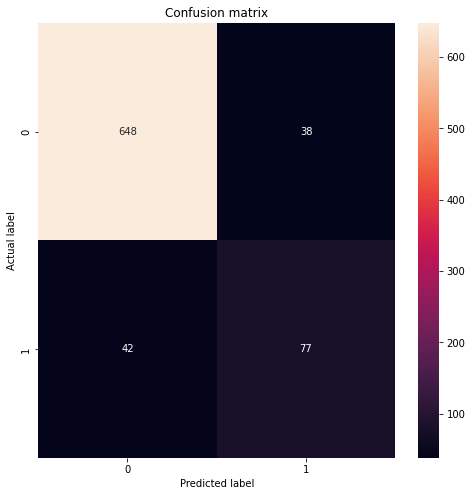

In [22]:
test_predictions_baseline = model.predict(test_features)
plot_cm(test_labels, test_predictions_baseline)
# 0 is 'alive', 1 is 'not alive'